In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

def features_heat_scatter(search_type, clf, param_grid, n_iter, X_train, y_train, X_test):
    # Randon vs Grid Search
    if search_type == 'Random':
        # Create a random search object
        CV_search = RandomizedSearchCV(
            estimator = clf,
            param_distributions = param_grid,
            n_iter = n_iter,
            scoring='roc_auc', 
            n_jobs=4, 
            cv = 5, 
            refit=True, 
            return_train_score = True
            )
    elif search_type == 'Grid':
        # Create a random search object
        CV_search = RandomizedSearchCV(
            estimator = clf,
            param_distributions = param_grid,
            n_iter = n_iter,
            scoring='roc_auc', 
            n_jobs=4, 
            cv = 5, 
            refit=True, 
            return_train_score = True
            )

    # Fit to the training data
    mdl = CV_search.fit(X_train, y_train)

    # Create dataframe of random grid search results
    params = list(param_grid.keys())
    heatdf = pd.DataFrame()
    for p in params:
        heatdf[p] = CV_search.cv_results_['param_' + p].tolist()

    heatdf['score'] = CV_search.cv_results_['mean_test_score'].tolist()
    heatdf.dropna(inplace=True)

    variables = list(range(0, len(params)))

    if len(variables) == 1:
        plt.rc('font', size=16)
        plt.figure(figsize = (12,6))
        plt.scatter(
            x = heatdf[list(param_grid.keys())[0]], 
            y = heatdf['score'],
        )
        plt.xlabel(list(param_grid.keys())[0])
        plt.ylabel('score')
        plt.show()

    elif len(variables) == 2:
        
        plt.rc('font', size=16)
        plt.figure(figsize = (12,6))
        plt.scatter(
            x = heatdf[list(param_grid.keys())[0]], 
            y = heatdf[list(param_grid.keys())[1]],
            c = heatdf['score'],
            cmap = 'gist_rainbow'
        )
        plt.xlabel(list(param_grid.keys())[0])
        plt.ylabel(list(param_grid.keys())[1])
        plt.colorbar()
        plt.show()

    else:
        dependent = []
        independent = []

        for v in variables:
            idx = v
            while idx <= max(variables):
                if v < idx:
                    dependent.append(params[v])
                    independent.append(params[idx])
                    idx += 1
                else:
                    idx += 1

        plot_inputs = pd.DataFrame({"input":dependent,"output":independent})

            # Subplots are organized in a Rows x Cols Grid
        Tot = plot_inputs.shape[0]
        Cols = np.ceil(Tot/4).astype(int)

        # Compute Rows required
        Rows = Tot // Cols 
        Rows += Tot % Cols

        cmap = plt.get_cmap("Spectral")
        norm = plt.Normalize(heatdf['score'].min(), heatdf['score'].max())

        plt.rc('font', size=12)
        fig, axs = plt.subplots(Rows, Cols, figsize=(14, 10))

        for i, r in plot_inputs.iterrows():

            axs.ravel()[i].set(xlabel=r['input'], ylabel=r['output'])
            axs.ravel()[i].scatter(
                x = heatdf[r['input']], 
                y = heatdf[r['output']],
                c = heatdf['score'],
                cmap = 'gist_rainbow'
            )      
            axs.ravel()[i].set(xlabel=r['input'], ylabel=r['output'])

        sm =  ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=axs)
        cbar.ax.set_title("scale")
        plt.show()
           
    heatdf.to_csv('data/heatmap.csv', index=False)
    return mdl

In [ ]:
# Load the training data
train = pd.read_csv('data/train.csv')

print('Original df shape: [' + train.shape[0].__str__() + ',' + train.shape[1].__str__() + ']')

# Break up stacked features
# Create feature of size of group
train[['group','groupNumber']]=train.PassengerId.str.split('_',expand=True)
GroupDF = pd.DataFrame(train['group'].value_counts(),)
GroupDF.reset_index(inplace=True)
GroupDF.columns = ['group', 'groupCount']
train = train.merge(
    GroupDF,
    on='group',
    how='left'
)

train[['deck','cabinNumber', 'side']]=train.Cabin.str.split('/',expand=True)

# Make an Unknown Deck
train.loc[train.deck.isna(), 'deck'] = 'unk'

# # Convert boolean to numbers
# train.CryoSleep = train.CryoSleep*1
# train.VIP = train.VIP*1
train.Transported = train.Transported*1

# Drop useless features
dropFeatures = [
    'Name', 'Destination', 'HomePlanet', 'CryoSleep','VIP','PassengerId','Cabin',
    'Age', 'side', 'cabinNumber', 'groupNumber', 'group'
]
train.drop(dropFeatures, axis=1, inplace=True)

# Fill NA money columns with 0
train[['RoomService','FoodCourt','ShoppingMall','Spa', 'VRDeck']] = \
    train[['RoomService','FoodCourt','ShoppingMall','Spa', 'VRDeck']].fillna(value=0)

# Makeup some new features
train['TotalSpent'] = train['RoomService'] + train['FoodCourt'] + \
    train['ShoppingMall'] + train['Spa'] + train['VRDeck']

# Sneak Peak!
train.head()

In [ ]:
# What data is missing?
train.isna().sum()[train.isna().sum() > 0]

In [ ]:
# Dump rows of missing data interpolation or filling doesn't make sense
train.dropna(inplace=True)

In [ ]:
# Correct data types
# train = train.astype({
#     "Group": int, 
#     "GroupNumber": int,
#     "CryoSleep":int,
#     "VIP":int,
#     "Transported":int,
#     'CabinNumber':int
# })
train = train.astype({
    "Transported":int,
    'groupCount': int
})
# Create some dummies
train = pd.get_dummies(train, drop_first = True)

print('Feature Processed df shape: [' + train.shape[0].__str__() + ',' + train.shape[1].__str__() + ']')

train.head()

In [ ]:
from biokit.viz import corrplot

corr_df = train.corr()
c = corrplot.Corrplot(corr_df)
c.plot()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, \
    AdaBoostClassifier, StackingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Create features and predictor
X = train.drop('Transported', axis=1)
y = train['Transported']

# Traing, test, and split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=123)

# Create classifiers
lr = LogisticRegression(max_iter = 500)
gnb = GaussianNB()
ada = AdaBoostClassifier()
grb = GradientBoostingClassifier()
rfc = RandomForestClassifier()
xgbc = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric = 'logloss')
svc = SVC()
sgd = SGDClassifier()
knn = KNeighborsClassifier()
hgbc = HistGradientBoostingClassifier()

clf_list = [
    (lr, "Logistic"),
    (gnb, "NaiveBayes"),
    (grb, 'GradientBoost'),
    (ada, 'AdaBoost'),
    (rfc, "RandomForest"),
    (xgbc, 'XGBoost'),
    (knn, 'KNN'),
    (hgbc, 'HIstGradient')
]

s = []
m = []
for i, (clf, name) in enumerate(clf_list):
    p = clf.fit(X_train, y_train).predict_proba(X_test)[:,1]
    s.append(accuracy_score(y_test, p.round()))
    m.append(name)

modelSelection = pd.DataFrame(m, columns=['Model'])
modelSelection['Score'] = s
modelSelection.sort_values("Score", inplace=True, ascending=False)

modelSelection

In [ ]:
# Create a Random Forest Classifier with specified criterion
clf = RandomForestClassifier(criterion='entropy')

# Create the parameter grid
param_grid = {
    'max_depth': list(range(20,100)), 
    'min_samples_leaf': list(range(10,50)),
    'max_features':['sqrt', 'log2']
} 

rfc_op = features_heat_scatter('Random' clf, param_grid, 50, X_train, y_train, X_test)

In [ ]:
# Create a Random Forest Classifier with specified criterion
clf = GradientBoostingClassifier()

# Create the parameter grid
param_grid = {
    'n_estimators': list(range(100,1000)), 
    'max_depth': list(range(1,100)),
    'max_features':['sqrt', 'log2']
} 

gbc_op = features_heat_scatter('Random', clf, param_grid, 50, X_train, y_train, X_test)

0.8056354226566993


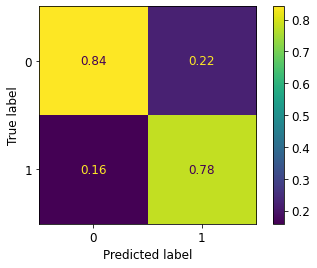

In [255]:
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import ConfusionMatrixDisplay

eclf = VotingClassifier(
    estimators=[
        ('RandomForest', rfc_op.best_estimator_), 
        ('GradientBoost', gbc_op.best_estimator_),
        ('XGB', xgbc)
        ],
    voting='soft')
pred = eclf.fit(X_train, y_train).predict(X_test)
# print(confusion_matrix(y_test, pred))
# print(accuracy_score(y_test, pred))

print(accuracy_score(y_test, pred))
ConfusionMatrixDisplay.from_predictions(y_test, pred, normalize = 'pred')


In [254]:
from sklearn.ensemble import StackingClassifier

estimators = [
    ('RandomForest', rfc_op.best_estimator_), 
    ('GradientBoost', gbc_op.best_estimator_),
    ('XGB', xgbc)
]
clf = StackingClassifier(
    estimators=estimators, 
    final_estimator=LogisticRegression()
)
print(accuracy_score(y_test, pred))
ConfusionMatrixDisplay.from_predictions(y_test, pred, normalize = 'pred')

ValueError: Found input variables with inconsistent numbers of samples: [1739, 4277]

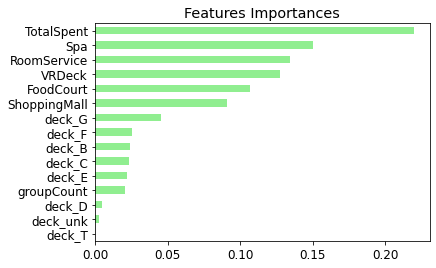

In [257]:
# Create a pd.Series of features importances
importances = pd.Series(data=rfc_op.best_estimator_.feature_importances_,
                        index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()


In [ ]:
# Load the testing data
test = pd.read_csv('data/test.csv')
p_id = test.PassengerId

print('Original df shape: [' + test.shape[0].__str__() + ',' + test.shape[1].__str__() + ']')

# Break up stacked features
# Create feature of size of group
test[['group','groupNumber']]=test.PassengerId.str.split('_',expand=True)
GroupDF = pd.DataFrame(test['group'].value_counts(),)
GroupDF.reset_index(inplace=True)
GroupDF.columns = ['group', 'groupCount']
test = test.merge(
    GroupDF,
    on='group',
    how='left'
)

test[['deck','cabinNumber', 'side']]=test.Cabin.str.split('/',expand=True)

# Make an Unknown Deck
test.loc[test.deck.isna(), 'deck'] = 'unk'

# Drop useless features
dropFeatures = [
    'Name', 'Destination', 'HomePlanet', 'CryoSleep','VIP','PassengerId','Cabin',
    'Age', 'side', 'cabinNumber', 'groupNumber', 'group'
]
test.drop(dropFeatures, axis=1, inplace=True)

# Fill NA money columns with 0
test[['RoomService','FoodCourt','ShoppingMall','Spa', 'VRDeck']] = \
    test[['RoomService','FoodCourt','ShoppingMall','Spa', 'VRDeck']].fillna(value=0)

# Makeup some new features
test['TotalSpent'] = test['RoomService'] + test['FoodCourt'] + \
    test['ShoppingMall'] + test['Spa'] + test['VRDeck']

test = test.astype({
    'groupCount': int
})
# Create some dummies
test = pd.get_dummies(test, drop_first = True)

# Sneak Peak!
test.head()

In [ ]:
eclf.set_params(voting= 'hard')

In [ ]:
pred = eclf.predict(test)
submission = pd.DataFrame()
submission['PassengerId'] = p_id
submission['Transported'] = pred.astype(bool)
submission.to_csv('data/submission.csv', index=False)

submission.head()